In [1]:
%load_ext autoreload
%matplotlib inline

/Users/diego/.pyenv/versions/miniconda-latest/lib/python2.7/site-packages/subprocess32.py:472: RuntimeWarning: The _posixsubprocess module is not being used. Child process reliability may suffer if your program uses threads.
  "program uses threads.", RuntimeWarning)


In [2]:
%autoreload 2

import torch
from torch.autograd import Variable
from torch import nn, optim
import torchvision.models
import numpy as np
import models, utils
from IPython import display

### Load trained VGG Model

In [3]:
net = models.ModifiedVGG()

### Load Content Image

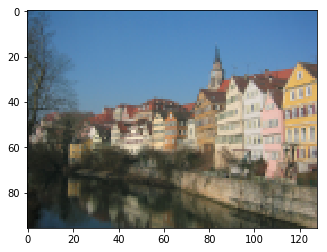

torch.Size([1, 3, 96, 128])

In [4]:
content_filename = 'tubingen.jpg'
content_tensor = utils.load_image(content_filename, max_size=(128,128))
content_var = utils.tensor_to_4d_var(content_tensor)
content_var.size()

### Load Style Image

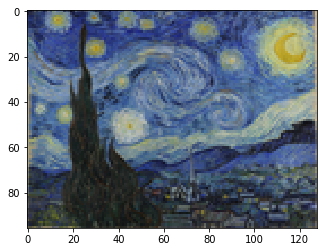

torch.Size([1, 3, 96, 128])

In [5]:
style_filename = 'starry-night.jpg'
style_tensor = utils.load_image(style_filename, shape=reversed(content_var.size()[2:]))
style_var = utils.tensor_to_4d_var(style_tensor)
style_var.size()

In [6]:
style_layer_names = ['conv1_1', 'conv2_1', 'conv3_1', 'conv4_1', 'conv5_1']
content_layer_names = ['conv4_2']

### Convert Style and Content images to Gram Matrix Representations

In [7]:
def representation(image_var, net, layer_names, gram):
    '''
    Return list with gram matrix representations of image_var
    '''
    # Obtain conv. layers output
    layers = net(image_var)[1]
    # Filter layers
    out = [layers[name] for name in layer_names]
    if gram:
        # Generate Gram matrices
        out = utils.gram_matrices(out)
    return out

In [8]:
content_repr = representation(content_var, net, content_layer_names, gram=False)
style_repr = representation(style_var, net, style_layer_names, gram=True)

### Create input Image

In [13]:
input_tensor = torch.randn(content_tensor.size()).float()#content_tensor.clone()
input_var = utils.tensor_to_4d_var(input_tensor, requires_grad=True)

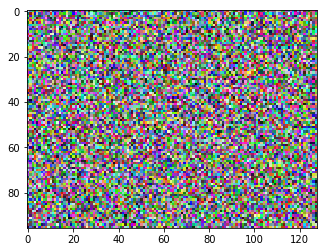

In [14]:
utils.display_image(input_var.data)

### Calculate Loss

In [15]:
def total_loss(target_content, target_style, input_content, input_style, content_weight=8, style_weight=10000):
    criterion_style, criterion_cont = nn.MSELoss(), nn.MSELoss()
    cl = utils.content_loss(criterion_cont, target_content, input_content)
    sl = utils.style_loss(criterion_style, target_style, input_style)
    return (content_weight * cl) + (style_weight * sl), cl, sl

### Train model

0
Total Loss: 2.33355426788
Content Loss: 0.291694283485
Style Loss: 2.00333714501e-18


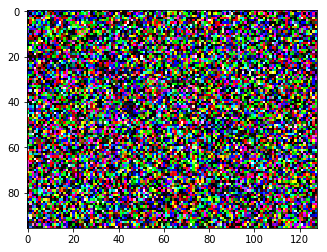

0
Total Loss: 2.33289837837
Content Loss: 0.291612297297
Style Loss: 2.00325587452e-18


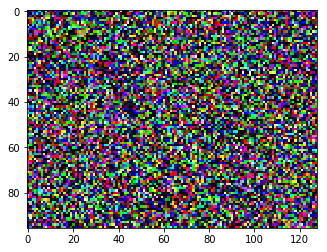

25
Total Loss: 3.55696463585
Content Loss: 0.444620579481
Style Loss: 1.72214586389e-17


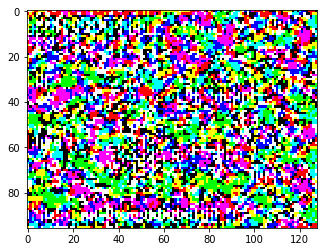

25
Total Loss: 3.55696463585
Content Loss: 0.444620579481
Style Loss: 1.72214586389e-17


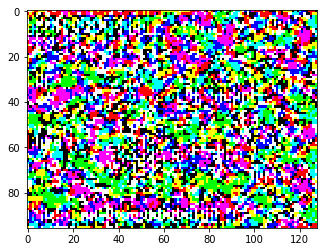

50
Total Loss: 3.55696463585
Content Loss: 0.444620579481
Style Loss: 1.72214586389e-17


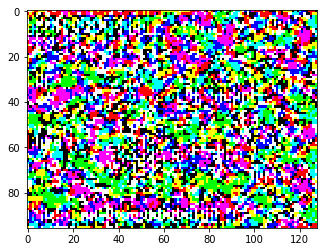

50
Total Loss: 3.55696463585
Content Loss: 0.444620579481
Style Loss: 1.72214586389e-17


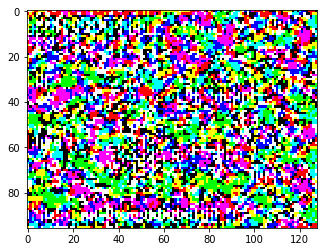

75
Total Loss: 3.55696463585
Content Loss: 0.444620579481
Style Loss: 1.72214586389e-17


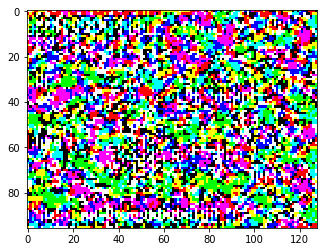

75
Total Loss: 3.55696463585
Content Loss: 0.444620579481
Style Loss: 1.72214586389e-17


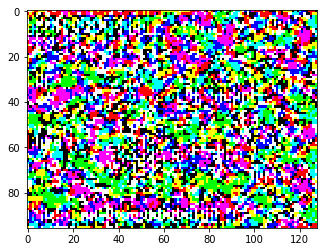

100
Total Loss: 3.55696463585
Content Loss: 0.444620579481
Style Loss: 1.72214586389e-17


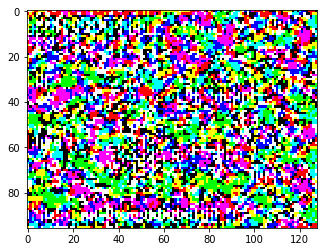

100
Total Loss: 3.55696463585
Content Loss: 0.444620579481
Style Loss: 1.72214586389e-17


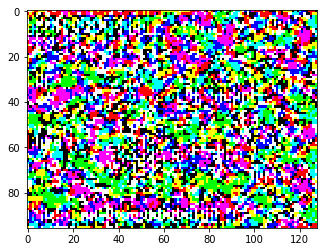

KeyboardInterrupt: 

In [17]:
epochs = 1000

# Load Optimizer
optimizer = optim.LBFGS([input_var])

for t in range(epochs):
    def closure():
        # correct the values of updated input image
        input_var.data.clamp_(0, 1)
        # Reset gradients
        optimizer.zero_grad()
        # Obtain Gram Matrix of Input Image
        input_content = representation(input_var, net, content_layer_names, gram=False)
        input_style = representation(input_var, net, style_layer_names, gram=True)
        # Calculate loss
        loss, c_loss, s_loss = total_loss(content_repr, style_repr, input_content, input_style)
        loss.backward()
        if t % 25 ==0:
            print(t)
            print('Total Loss: {}'.format(loss.data[0]))
            print('Content Loss: {}'.format(c_loss.data[0]))
            print('Style Loss: {}'.format(s_loss.data[0]))
            utils.display_image(input_var.data.clamp(0, 1))
        return loss
    
    optimizer.step(closure)
#     display.clear_output(wait=True)